# Importando pacotes

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from pycountry_convert import country_name_to_country_alpha2


# Funções

In [2]:
def get_country_code(country):
    try:
        country_code =  country_name_to_country_alpha2(country)
    except:
        country_code = np.nan 

    return country_code

def obter_localizacao(country):
    df = pd.read_csv('../data/geolocation_data/countries.csv',index_col='code')

    return tuple(df.loc[get_country_code(f'{country}'),['latitude','longitude']]) 


def new_map():
    return  folium.Map(tiles='https://{s}.basemaps.cartocdn.com/dark_all/{z}/{x}/{y}{r}.png',attr='my-portfolium')

def add_country(mapa,country):
    localizacao =  obter_localizacao(country)
    folium.CircleMarker(location= localizacao,
                    radius=5,
                    color='red',
                    tooltip=country ,
                    fill=True,
                    fill_color='red').add_to(mapa)


# Carregando dados

In [3]:
salarios = pd.read_csv('../data/career_data/data_science_salaries.csv')
salarios.head()

,job_title,experience_level,employment_type,work_models,work_year,employee_residence,salary,salary_currency,salary_in_usd,company_location,company_size
0,Data Engineer,Mid-level,Full-time,Remote,2024,United States,148100,USD,148100,United States,Medium
1,Data Engineer,Mid-level,Full-time,Remote,2024,United States,98700,USD,98700,United States,Medium
2,Data Scientist,Senior-level,Full-time,Remote,2024,United States,140032,USD,140032,United States,Medium
3,Data Scientist,Senior-level,Full-time,Remote,2024,United States,100022,USD,100022,United States,Medium
4,BI Developer,Mid-level,Full-time,On-site,2024,United States,120000,USD,120000,United States,Medium


# Integridade da base

verificando as dimensoes da base:

* 6599 instâncias

* 11 variáveis

In [4]:
salarios.shape

(6599, 11)

Sem valores duplicados

In [5]:
salarios.duplicated().sum()

0

Sem valores nulos

In [6]:
salarios.isna().sum()

job_title             0
experience_level      0
employment_type       0
work_models           0
work_year             0
employee_residence    0
salary                0
salary_currency       0
salary_in_usd         0
company_location      0
company_size          0
dtype: int64

Verificando com mais detalhes as variavéis e seus tipos

In [7]:
salarios.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6599 entries, 0 to 6598
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   job_title           6599 non-null   object
 1   experience_level    6599 non-null   object
 2   employment_type     6599 non-null   object
 3   work_models         6599 non-null   object
 4   work_year           6599 non-null   int64 
 5   employee_residence  6599 non-null   object
 6   salary              6599 non-null   int64 
 7   salary_currency     6599 non-null   object
 8   salary_in_usd       6599 non-null   int64 
 9   company_location    6599 non-null   object
 10  company_size        6599 non-null   object
dtypes: int64(3), object(8)
memory usage: 3.5 MB


Aparentemente tudo dentro dos conformes. Base pequena com poucos dados e ocupando pouca memoria (3.5MB)

ponto de melhora : alterar as variaveis object para string ou categoricas

Variáveis/Features:

| Variável | Descrição |
|---|---|
| experience_level | Nível de expeeriência do indivíduo |
| employment_type | Tipo de contratação |
| work_models | Modelo de trabalho (remoto, home office e etc..) |
| work_year | Ano com relação a esse emprego. |
| employee_residence | Local de residência do empregado |
| salary | Salário informado na moeda local |
| salary_currency | Moeda em que o salário é denominado |
| salary_in_usd | Salário convertido para dolares |
| company_location | Local geográfico da empresa contratante |
| company_size | Tamanho da empresa categorizado de acordo com a quantidade de funcionários |
 

# Adicionando novas variáveis

In [8]:
# Criando uma nova coluna auxiliar para utilizarmos de referencia
salarios['salario_brl_mes'] = salarios['salary_in_usd']*5/12

---------------

## Obtendo estatísticas básicas



In [9]:
salarios.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
work_year,6599.0,2022.82,0.67,2020.0,2023.00,2023.0,2023.00,2024.0
salary,6599.0,179283.26,526372.24,14000.0,96000.00,140000.0,187500.00,30400000.0
salary_in_usd,6599.0,145560.56,70946.84,15000.0,95000.00,138666.0,185000.00,750000.0
salario_brl_mes,6599.0,60650.23,29561.18,6250.0,39583.33,57777.5,77083.33,312500.0


In [10]:
salarios.describe(include='object').T

,count,unique,top,freq
job_title,6599,132,Data Engineer,1307
experience_level,6599,4,Senior-level,4105
employment_type,6599,4,Full-time,6552
work_models,6599,3,On-site,3813
employee_residence,6599,87,United States,5305
salary_currency,6599,22,USD,5827
company_location,6599,75,United States,5354
company_size,6599,3,Medium,5860


**Insights**

* Observamos que ao menos 50% dos dados são referentes ao ano de 2023, obtemos isso comparando o 1°quartil com o 3°quartil, cuja diferença corresponde a 50%

* Os dados foram obtidos num intervalo de 5 anos, com inicio em 2020 e com fim em janeiro de 2024.

* Vamos ignorar o salário dado em termos regionais, pois não faz sentido olhar as estatísticas de um salario em dolar o outro reais e o outro em libras esterlinas, por exemplo. Faz mais sentido olharmos para todos os salários convertidos para doláres, é como se estivessem em uma mesma escala.

* O dono do dataset não apresenta muitas informações acerca do salário, mas suponhamos que sejam salários anuais, visto que é uma prática muito comum na gringa.

* O maior salário corresponde a \\$750.000 anuais, ou  R\\$312.500 por mês tomando uma cotação de 1 para 5

* O menor salário corresponde a \\$15.000 anuais. O que equivale a R\\$6.250 por mês no Brasil tomando uma cotação de 5 reais o dolar

* Metade dos salarios se encontram entre \\$90.000 anuais. Equivalente em R\\$37.500 por mês.

* O desvio padrão é demasiadamente alto, cerca de R\\$29.561,18 por mês.

* Na mediana o salário se encontra em \\$138.666, equivalente a R\\$57.777,50 por mês.

* Observamos que a Mediana e a Média são relativamente próximas.

* O cargo com maiores contratações corresponde ao do Engenheiro de dados, com 1307 (19,81\%) instâncias

* A maioria das contratações ocorrem para indivíduos  com nível senior. São 4105 (62,21\%) instâncias 

* Os trabalhos em sua maioria (99,29\%) são em regime integral. E  57,78\% de todos os trabalhos são presenciais.

* Grande parte de todos os trabalhos estão sendo pago em Doláres,bem como a maioria das empresas são dos Estados Unidos.

* 88,80\% das empresas são consideradas de porte médio. 

# Univariado

## Categóricos

---
**Job Title / Profissão**


In [11]:
salarios['job_title'].nunique()

132

In [12]:
salarios['job_title'].unique()

array(['Data Engineer', 'Data Scientist', 'BI Developer',
       'Research Analyst', 'Business Intelligence Developer',
       'Data Analyst', 'Director of Data Science', 'MLOps Engineer',
       'Machine Learning Scientist', 'Machine Learning Engineer',
       'Data Science Manager', 'Applied Scientist',
       'Business Intelligence Analyst', 'Analytics Engineer',
       'Business Intelligence Engineer', 'Data Science',
       'Research Scientist', 'Research Engineer',
       'Managing Director Data Science', 'AI Engineer', 'Data Specialist',
       'Data Architect', 'Data Visualization Specialist', 'ETL Developer',
       'Data Science Practitioner', 'Computer Vision Engineer',
       'Data Lead', 'ML Engineer', 'Data Developer', 'Data Modeler',
       'Data Science Consultant', 'AI Architect',
       'Data Analytics Manager', 'Data Science Engineer',
       'Data Product Manager', 'Data Quality Analyst', 'Data Strategist',
       'Prompt Engineer', 'Data Science Lead',
       'Busi

Análisando a lista de profissões nós identificamos algumas redundâncias, por exemplo:  Dentre as profissões há Machine Learning Engineer e ML Engineer, temos também Data Scientist e Data Science.

Pedi ao chatgpt me indicar todas as possíveis redundancias na lista e a resposta dele está listada a seguir:

1. **Business Intelligence Developer** e **BI Developer**: Ambos os termos se referem a desenvolvedores de inteligência de negócios, e "BI" é uma abreviação comum para "Business Intelligence".
2. **Data Analyst** e **Business Data Analyst**: Ambos os profissionais estão envolvidos na análise de dados para fins comerciais, e a inclusão de "Business" em "Business Data Analyst" não adiciona uma distinção significativa.
3. **Machine Learning Engineer** e **ML Engineer**: "ML" é uma abreviação comum para "Machine Learning", então ambos os termos descrevem a mesma função.
4. **Data Manager** e **Data Management Analyst**: Ambos estão envolvidos na gestão de dados, e a inclusão de "Analyst" em "Data Management Analyst" não adiciona uma distinção significativa.
5. **Data Quality Analyst** e **Data Quality Engineer**: Ambos estão envolvidos na garantia da qualidade dos dados, e a inclusão de "Engineer" em "Data Quality Engineer" não adiciona uma distinção significativa.
6. **Data Quality Manager** e **Data Quality Engineer**: Ambos estão envolvidos na gestão da qualidade dos dados, e a inclusão de "Manager" em "Data Quality Manager" não adiciona uma distinção significativa.
7. **Data Visualization Specialist** e **Data Visualization Engineer**: Ambos estão envolvidos na visualização de dados, e a inclusão de "Engineer" em "Data Visualization Engineer" não adiciona uma distinção significativa.
8. **Machine Learning Scientist** e **Principal Data Scientist**: Ambos os termos descrevem profissionais que trabalham com algoritmos de aprendizado de máquina e análise de dados, e a inclusão de "Principal" não adiciona uma distinção significativa.
9. **Principal Machine Learning Engineer** e **Staff Machine Learning Engineer**: Ambos os termos descrevem profissionais que trabalham com algoritmos de aprendizado de máquina, e a inclusão de "Principal" ou "Staff" não adiciona uma distinção significativa.
10. **Lead Machine Learning Engineer** e **Machine Learning Manager**: Ambos os termos descrevem profissionais que lideram projetos de aprendizado de máquina, e a inclusão de "Lead" em "Lead Machine Learning Engineer" não adiciona uma distinção significativa.
11. **Marketing Data Scientist** e **Marketing Data Analyst**: Ambos os profissionais estão envolvidos na análise de dados para fins de marketing, e a inclusão de "Scientist" em "Marketing Data Scientist" não adiciona uma distinção significativa.
12. **AI Scientist** e **AI Research Engineer**: Ambos os termos descrevem profissionais que trabalham com inteligência artificial, e a inclusão de "Engineer" em "AI Research Engineer" não adiciona uma distinção significativa.
13. **Data Integration Specialist** e **Data Integration Engineer**: Ambos estão envolvidos na integração de sistemas e dados, e a inclusão de "Engineer" em "Data Integration Engineer" não adiciona uma distinção significativa.
14. **Data Management Specialist** e **Manager Data Management**: Ambos estão envolvidos na gestão de dados, e a inclusão de "Manager" em "Manager Data Management" não adiciona uma distinção significativa.
15. **Data Scientist** e **Data Science**: Ambos estão relacionados ao campo geral de ciência de dados, com "Data Scientist" representando um profissional e "Data Science" representando a disciplina como um todo.

Essa lista foi obtida depois de alguns prompts. Ainda existe o questionamento se de fato todos os listados são redundantes, mas me parece bem mais consistente.


Realizar o replace pode ser interessante ou não dependendo do que desejamos analisar. Explico:

1. A redundancia pode ser interessante para termos noção de quantos termos existem no mercado para uma mesma profissão e isso pode ser um resultado interessante. 

2. Ter muitas variancias para o mesmo nome pode ser prejudicial caso queiramos analisar qual a profissão mais "popular". Com muitas variantes seria mais complicado realizar esse tipo de análise. 

A seguir eu deixo o código que realiza a remoçã de redundancia.

In [13]:
#to_replace = {
#    "Business Intelligence Developer": "BI Developer",
#    "Business Data Analyst": "Data Analyst",
#    "ML Engineer": "Machine Learning Engineer",
#    "Data Management Analyst": "Data Manager",
#    "Data Quality Engineer": "Data Quality Analyst",
#    "Data Quality Engineer": "Data Quality Manager",
#    "Data Visualization Engineer": "Data Visualization Specialist",
#    "Principal Data Scientist": "Machine Learning Scientist",
#    "Staff Machine Learning Engineer": "Principal Machine Learning Engineer",
#    "Machine Learning Manager": "Lead Machine Learning Engineer",
#    "Marketing Data Analyst": "Marketing Data Scientist",
#    "AI Research Engineer": "AI Scientist",
#    "Data Integration Engineer": "Data Integration Specialist",
#    "Manager Data Management": "Data Management Specialist",
#    "Data Science": "Data Scientist"
#}

#salarios = salarios.replace(to_replace)

In [14]:
aux = salarios['job_title'].value_counts(1).sort_values(ascending=False).mul(100).nlargest(26).round(2).to_frame('proporcao')
aux['cumsum'] = aux['proporcao'].cumsum()
aux

,proporcao,cumsum
job_title,,
Data Engineer,19.81,19.81
Data Scientist,18.84,38.65
Data Analyst,13.79,52.44
Machine Learning Engineer,9.53,61.97
Analytics Engineer,3.73,65.70
Research Scientist,3.12,68.82
Data Architect,2.67,71.49
Research Engineer,2.06,73.55
ML Engineer,1.71,75.26


**Insights**

* São registradas 132 profissões diferentes relacionadas a dados

* Existem redundâncias, por exemplo:  Dentre as profissões há Machine Learning Engineer e ML Engineer, temos também Data Scientist e Data Science.

* Há muitas profissões na área de dados, mas as três principais são Engenharia de dados (19,81%), Ciência de dados (18,84%) e Análista de dados (13,79%). Juntas elas correspondem a 52,44% de toda a base sem levar em consideração as redundâncias.


---
**Experience level / Nível de experiência**

In [15]:
salarios['experience_level'].unique().tolist()

['Mid-level', 'Senior-level', 'Entry-level', 'Executive-level']

In [16]:
aux = salarios['experience_level'].value_counts(1).sort_values(ascending=False).mul(100).round(2).to_frame('proporcao')
aux['cumsum'] = aux['proporcao'].cumsum()
aux

,proporcao,cumsum
experience_level,,
Senior-level,62.21,62.21
Mid-level,25.38,87.59
Entry-level,8.56,96.15
Executive-level,3.85,100.00


**Insights**

* Existem 4 hierarquias que distinguem os profissionais de dados.
    * Senior-level corresponde ao que denominamos por sênior
    * Mid-level é o equivalente a pleno
    * Entry-level seria o Junior, e aqui não sabemos se trainee e estagiarios são levados e consideração
    * Executive-level corresponde os profisionais de dados mais voltados ao negócio, por exemplo os head of data.
    
* O sênior é o tipo de profissional mais requisitado pelo mercado, onde 62,21\% da base corresponde a esse tipo.

* Com 25,38% vem o profissional pleno

* Com 8,56% estão os juniores.

* E os profissionais executivos com 3,85%
    

___

**work_models / Modelo de trabalho**

In [17]:
salarios['work_models'].unique()

array(['Remote', 'On-site', 'Hybrid'], dtype=object)

In [18]:
aux = salarios['work_models'].value_counts(1).sort_values(ascending=False).mul(100).round(2).to_frame('proporcao')
aux['cumsum'] = aux['proporcao'].cumsum()
aux

,proporcao,cumsum
work_models,,
On-site,57.78,57.78
Remote,38.81,96.59
Hybrid,3.41,100.00


**Insights**

* 57.78\% dos trabalhos são presenciais, enquanto 38,81\% são remotos

* Trabalhos hibridos são a minoria com 3,41\% da base.

---
**Work_year / Ano**

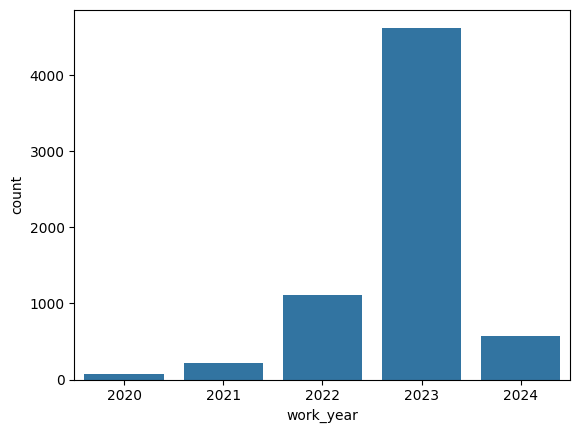

In [19]:
sns.countplot(data=salarios,x='work_year');

**Insights**

* Notamos que a quantidade de empregos não é uniforme com o tempo. É claro o aumento do uso da plataforma durante os anos. Isso pode ter ocorrido devido a plataforma ter ficado popular? o Boom da área de dados? 

---
**employee_residence / Residência do empregado**

In [20]:
salarios['employee_residence'].nunique()

87

In [21]:
salarios['employee_residence'].unique()

array(['United States', 'Romania', 'Portugal', 'Lebanon', 'India',
       'Ireland', 'United Kingdom', 'Spain', 'Egypt', 'Germany', 'Canada',
       'Australia', 'Vietnam', 'Uganda', 'Italy', 'Thailand',
       'Philippines', 'Tunisia', 'Belgium', 'Turkey', 'Nigeria',
       'Uzbekistan', 'Argentina', 'France', 'Kuwait', 'Ukraine',
       'South Africa', 'Slovenia', 'Singapore', 'Sweden', 'Saudi Arabia',
       'Armenia', 'Russia', 'Georgia', 'Qatar', 'Peru', 'Poland',
       'New Zealand', 'Norway', 'Netherlands', 'Mexico', 'Latvia',
       'Pakistan', 'Lithuania', 'South Korea', 'Kenya', 'Moldova',
       'Israel', 'Hungary', 'Croatia', 'Hong Kong', 'Greece', 'Ghana',
       'Finland', 'Estonia', 'Cyprus', 'Ecuador', 'Austria', 'Colombia',
       'Switzerland', 'Central African Republic', 'Czech Republic',
       'Brazil', 'Bosnia and Herzegovina', 'Andorra', 'China',
       'Costa Rica', 'Chile', 'Bolivia', 'Malaysia',
       'United Arab Emirates', 'Puerto Rico', 'Japan', 'Iran',
 

In [22]:
aux = salarios['employee_residence'].value_counts(1).sort_values(ascending=False).mul(100).round(2).to_frame('proporcao')
aux['cumsum'] = aux['proporcao'].cumsum()
aux.head(20)

,proporcao,cumsum
employee_residence,,
United States,80.39,80.39
United Kingdom,6.08,86.47
Canada,3.65,90.12
Germany,1.08,91.20
India,1.06,92.26
Spain,1.02,93.28
France,0.80,94.08
Australia,0.44,94.52
Portugal,0.42,94.94


In [23]:
mapa_empregados = new_map()

for country in salarios['employee_residence'].unique():
    add_country(mapa_empregados,country)

mapa_empregados

/home/alexandre/.cache/pypoetry/virtualenvs/dive-into-data-careers-Vh_zOGtm-py3.10/lib/python3.10/site-packages/pycountry/db.py:51: UserWarning: Country's official_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)
/home/alexandre/.cache/pypoetry/virtualenvs/dive-into-data-careers-Vh_zOGtm-py3.10/lib/python3.10/site-packages/pycountry/db.py:51: UserWarning: Country's common_name not found. Country name provided instead.
  warnings.warn(warning_message, UserWarning)


**Insights**

* Observamos pessoas de 87 países diferentes.

* A maioria das pessoas (80,39\%) residem nos Estados Unidos.

* O Brasil se encontra em 12° com apenas 0,29\% da base. 

* O top 10 é formado majoritariamente por países da América do Norte e Europa, exceto pela India e Australia.

---
**company_location / Localização da empresa**

In [24]:
salarios['company_location'].nunique()

75

In [25]:
salarios['company_location'].unique()

array(['United States', 'Romania', 'Portugal', 'Lebanon', 'India',
       'Ireland', 'United Kingdom', 'Spain', 'Egypt', 'Germany', 'Canada',
       'Australia', 'Vietnam', 'Ukraine', 'Turkey', 'Thailand',
       'South Africa', 'Slovenia', 'Singapore', 'Sweden', 'Saudi Arabia',
       'Russia', 'Qatar', 'Poland', 'Philippines', 'New Zealand',
       'Norway', 'Netherlands', 'Nigeria', 'Mexico', 'Latvia',
       'Luxembourg', 'Lithuania', 'South Korea', 'Kenya', 'Japan',
       'Italy', 'Israel', 'Hungary', 'Croatia', 'Hong Kong', 'Greece',
       'Gibraltar', 'Ghana', 'France', 'Finland', 'Estonia', 'Ecuador',
       'Denmark', 'Czech Republic', 'Colombia', 'Switzerland',
       'Central African Republic', 'Brazil', 'Bosnia and Herzegovina',
       'Armenia', 'Argentina', 'Andorra', 'United Arab Emirates',
       'Puerto Rico', 'Pakistan', 'Malaysia', 'Iran', 'Indonesia',
       'Algeria', 'Belgium', 'Austria', 'Malta', 'Moldova', 'Iraq',
       'China', 'Chile', 'Bahamas', 'Mauritius

In [26]:
aux = salarios['company_location'].value_counts(1).sort_values(ascending=False).mul(100).round(2).to_frame('proporcao')
aux['cumsum'] = aux['proporcao'].cumsum()
aux.head(20)

,proporcao,cumsum
company_location,,
United States,81.13,81.13
United Kingdom,6.18,87.31
Canada,3.68,90.99
Germany,1.18,92.17
Spain,0.95,93.12
India,0.88,94.00
France,0.74,94.74
Australia,0.48,95.22
Portugal,0.39,95.61


In [27]:
mapa_empresas = new_map()

for country in salarios['company_location'].unique():
    add_country(mapa_empresas,country)
    
mapa_empresas

**Insights**

* As empresas européias e norte americanas são as que  mais contratam.

---

**company_size / Tamanho da empresa**

<Axes: xlabel='company_size', ylabel='count'>

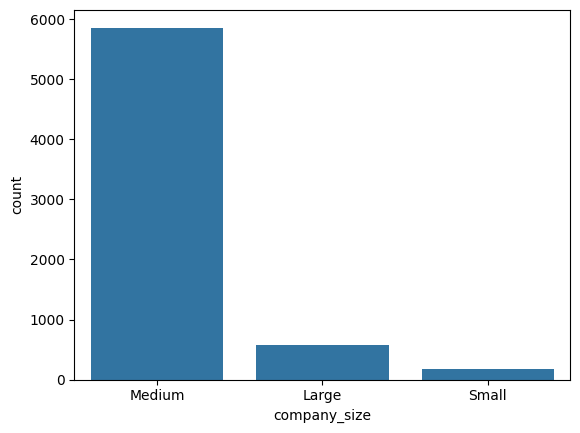

In [28]:
sns.countplot(data=salarios,x='company_size')

In [29]:
aux = salarios['company_size'].value_counts(1).sort_values(ascending=False).mul(100).round(2).to_frame('proporcao')
aux['cumsum'] = aux['proporcao'].cumsum()
aux

,proporcao,cumsum
company_size,,
Medium,88.80,88.80
Large,8.62,97.42
Small,2.58,100.00


**Insights**

* Observamos que a maioria das empresas são de tamanho médio (88,80\%). Um tamanho médio talvez possa ser considerado por algumas centenas de empregados. Isso pode nos indicar uma maturidade e estabilidade das empresas presentes na base. 

---
**salary_currency / Moeda**

In [30]:
salarios['salary_currency'].nunique()

22

In [31]:
aux = salarios['salary_currency'].value_counts(1).sort_values(ascending=False).mul(100).round(2).to_frame('proporcao')
aux['cumsum'] = aux['proporcao'].cumsum()
aux

,proporcao,cumsum
salary_currency,,
USD,88.30,88.30
GBP,5.06,93.36
EUR,4.42,97.78
INR,0.77,98.55
CAD,0.59,99.14
AUD,0.17,99.31
PLN,0.11,99.42
SGD,0.09,99.51
CHF,0.08,99.59


**Insights**

* Há moedas de 22 países diferentes em negociação, apesar de termos empresas de 75 países diferentes e pessoas de 87 países diferentes.

* As moedas mais presentes são o Dolar, Euro, Libra Esterlina, Rupia indiana, Dolar Canadense e etc...

# Numéricas


# **Perguntas**


1. Vimos uma série de profissoes relacionadas a dados. É possível que exista alguma terminologia/profissão que surgiu mais recente devido a popularização da área?

2. Existe alguma difrença entre o nível de profissionais que as empresas estão contrando ao decorrer dos anos? 

3. Existe alguma diferença notável entre as vagas presenciais e remotas com o passar dos anos?

4. A presença brasileira no site e no mercado internacional está aumentando? O Brasil representa alguma vantagem para os empregadores gringos?

5. As pessoas preferem trabalhar para a gringa ou para empresas de seus próprios países?

6. Vimos que a Rúpia Indiana é uma das moedas mais utilizados. Isso se deve a grande presença de empresas indianas na base de dados? 